# Week 3 Kaggle Mini-Project: Histopathologic Cancer Detection

### By: Julian Moscotte


### Introduction

In this project, I will be creating an algorithm to identify metastatic cancer in small image patches taken from larger digital pathology scans. The goal for this project is to correctly classify if the middle 32 x 32 pixels contain any tumor tissue. This will require the applications of machine learning techniques, including computer vision and deep learning to interpret the visual data and detect cancerous regions. 

#### The Data
We will be using the PatchCamelyon data set that has been slightly modified to remove duplicates. This dataset has a large number of small pathology images to classify. We are given a training set and a test dataset with ground truth labels.




In [6]:
import os
import cv2

print(len(os.listdir('./data/histopathologic-cancer-detection/train')))
print(len(os.listdir('./data/histopathologic-cancer-detection/test')))



# Path to your images folder
image_folder = './data/histopathologic-cancer-detection/train'

# List all files in the directory
for filename in os.listdir(image_folder):
    if filename.lower().endswith('.tif'):  # Check for .tif extension
        image_path = os.path.join(image_folder, filename)
        # Read the image
        img = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
        
        if img is not None:
            # Get dimensions
            height, width = img.shape[:2]
            print(f"Image: {filename} - Dimensions: {width}x{height}")
            break
        else:
            print(f"Failed to load image: {filename}")


220025
57458
Image: 00001b2b5609af42ab0ab276dd4cd41c3e7745b5.tif - Dimensions: 96x96


##### Key Characteristics

- Size: The dataset contains a large number of image patches with the training set containing 220025 images and the test set containing 57458 images. 
- Dimension: Each image is a 96 x 96 pixel image
- Structure: We get a training folder with all training images, a csv file with id and label for each image in the entire set, and a testing folder with all testing images. 

### Exploratory Data Analysis (EDA)

Now lets take a look at the data itself and describe what we have. As we saw in the introduction we have 684 training images and 57458 testing images. Now we'll take a look at the label file we have to confirm image ID's and labels. 1 being cancerous cell detected and 0 being not detected.

In [7]:
import pandas as pd

labels_df = pd.read_csv('./data/histopathologic-cancer-detection/train_labels.csv')
labels_df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


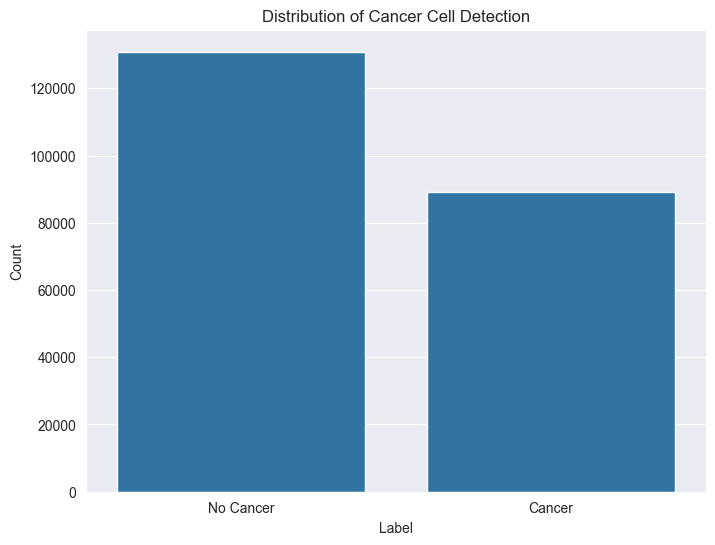

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# Plot the distribution of labels
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=labels_df)
plt.title('Distribution of Cancer Cell Detection')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['No Cancer', 'Cancer'])
plt.show()

Here we can see that the majority of these training images are non-cancerous, however there is still around 9000 cancerous images for us to build our model around. Lets take a look at some of the images themselves.

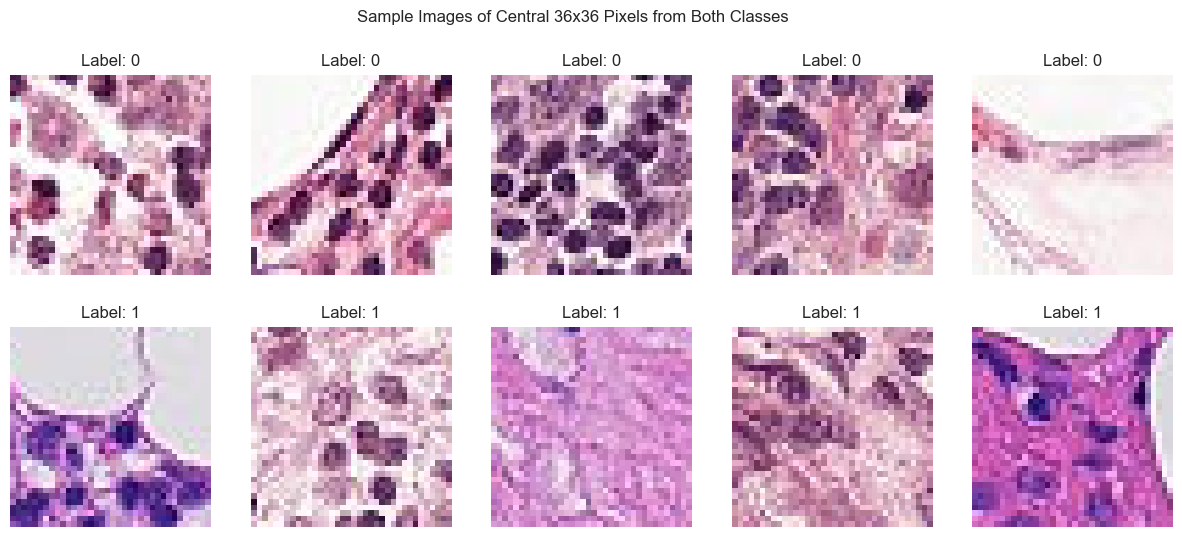

In [9]:
def display_samples_central_region(df, num_samples=5, img_folder=image_folder):
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))

    for i, label in enumerate([0, 1]):
        samples = df[df['label'] == label].sample(num_samples)
        for j, img_id in enumerate(samples['id'].values):
            img_path = os.path.join(img_folder, f'{img_id}.tif')
            img = Image.open(img_path)

            # Calculate the center region coordinates
            width, height = img.size
            left = (width - 36) // 2
            top = (height - 36) // 2
            right = left + 36
            bottom = top + 36

            # Crop the image to the central 36x36 pixels
            img_central = img.crop((left, top, right, bottom))

            axes[i, j].imshow(img_central)
            axes[i, j].axis('off')
            axes[i, j].set_title(f'Label: {label}')
    
    plt.suptitle('Sample Images of Central 36x36 Pixels from Both Classes')
    plt.show()

# Display sample images
display_samples_central_region(labels_df)


Without having any medical training it's difficult to visually tell what constitutes a tumor cell from an image however there are some similarities to the rows, separated along label (0,1). Lets do some data cleaning on the dataset to make sure we have quality data for our model. 

In [10]:
# Check for missing labels
missing_labels = labels_df['label'].isnull().sum()
print(f'Missing labels: {missing_labels}')

# Check if each image in the train folder has a corresponding label
img_folder = image_folder
image_ids = [fname.split('.')[0] for fname in os.listdir(img_folder) if fname.endswith('.tif')]
missing_images = set(labels_df['id']) - set(image_ids)

print(f'Missing images: {len(missing_images)}')


Missing labels: 0
Missing images: 0


Looks like we're working with a full dataset, so lets get rolling with a plan of analysis. For this project we will be using a Convolutional Neural Network (CNN) to classify these images as cancerous/non-cancerous. We will implement some data augmentation, given the small size of the 36x36 region to be considered, to help prevent overfitting and improve generalization. Lastly we'll try to address any class imbalance through techniques like oversampling/under sampling or using class weights. 

### Model Architecture

The first model we're going to use is a baseline CNN architecture with an input layer, 2 convolutional layers, fully connected layers, and lastly an output layer. This model will be relatively shallow with just 2 convolutional layers but this is fitting given the the small size of the input images. This should be good enough to capture spatial hierarchies without overfitting. We'll also use ReLU Activation to introduce non-linearity and help the model learn complex patterns. Lastly we'll have a sigmoid output since this is a binary classification. 

For comparison we'll create some deeper CNN's with additional convolutional layers. We'll try with a 3rd layer with 128 filters and later a 4th layer with 256 neurons. This will help capture more complex patterns and hopefully improve accuracy. 

We'll also try creating a Fully Convolutional Network (FCN) without any fully connected layers to see how it compares.

As for the Hyperparameter Tuning, we'll play around with things like the learning rate, batch size, optimizers, regularization, and data augmentation.  

#### Baseline CNN

In [11]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from PIL import Image
import pandas as pd
import numpy as np
import os
import random

# Set seeds for reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Reduce dataset size
train_size = 50000
validation_size = int(0.1 * train_size)  # Use 10% of the train set for validation

# Sample the data
train_labels_df = labels_df.sample(n=train_size, random_state=42)
validation_labels_df = labels_df.drop(train_labels_df.index).sample(n=validation_size, random_state=42)

# Custom Dataset class
class PathologyDataset(tf.data.Dataset):
    def __new__(cls, labels_df, img_folder, transform=None):
        def generator():
            for idx in range(len(labels_df)):
                img_id = labels_df.iloc[idx, 0]
                label = labels_df.iloc[idx, 1]
                img_path = os.path.join(img_folder, f'{img_id}.tif')
                image = Image.open(img_path)

                # Extract the central 36x36 pixels
                width, height = image.size
                left = (width - 36) // 2
                top = (height - 36) // 2
                right = left + 36
                bottom = top + 36
                image = image.crop((left, top, right, bottom))

                image = np.array(image) / 255.0  # Normalize to [0, 1]
                if transform:
                    image = transform(image)

                yield image, label

        return tf.data.Dataset.from_generator(generator, output_signature=(
            tf.TensorSpec(shape=(36, 36, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(), dtype=tf.int64)))

train_dataset = PathologyDataset(train_labels_df, img_folder).shuffle(buffer_size=train_size).batch(32).repeat()
validation_dataset = PathologyDataset(validation_labels_df, img_folder).batch(32)

# Define the CNN model
def create_cnn_model():
    model = models.Sequential([
        layers.Input(shape=(36, 36, 3)),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

# Instantiate and compile the model
basic_model = create_cnn_model()
basic_model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
num_epochs = 10
steps_per_epoch = min(train_size // 32, len(train_labels_df) // 32)
validation_steps = min(validation_size // 32, len(validation_labels_df) // 32)

basic_model.fit(train_dataset, epochs=num_epochs, steps_per_epoch=steps_per_epoch, validation_data=validation_dataset, validation_steps=validation_steps)

Epoch 1/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 338s 27ms/step - accuracy: 0.7137 - loss: 0.5542 - val_accuracy: 0.7648 - val_loss: 0.5014
Epoch 2/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 144s 93ms/step - accuracy: 0.7740 - loss: 0.4876 - val_accuracy: 0.8750 - val_loss: 0.2313
Epoch 3/10
   1/1562 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - accuracy: 0.8750 - loss: 0.3609

C:\Users\jmosc\AppData\Local\Programs\Python\Python311\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 64s 41ms/step - accuracy: 0.7916 - loss: 0.4593 - val_accuracy: 0.7977 - val_loss: 0.4488
Epoch 4/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 51s 33ms/step - accuracy: 0.7952 - loss: 0.4482 - val_accuracy: 0.8750 - val_loss: 0.3015
Epoch 5/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 63s 41ms/step - accuracy: 0.8018 - loss: 0.4419 - val_accuracy: 0.8107 - val_loss: 0.4405
Epoch 6/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 52s 33ms/step - accuracy: 0.8115 - loss: 0.4210 - val_accuracy: 1.0000 - val_loss: 0.1478
Epoch 7/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 64s 41ms/step - accuracy: 0.8215 - loss: 0.4026 - val_accuracy: 0.8051 - val_loss: 0.4514
Epoch 8/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 52s 33ms/step - accuracy: 0.8243 - loss: 0.3964 - val_accuracy: 1.0000 - val_loss: 0.1377
Epoch 9/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 64s 41ms/step - accuracy: 0.8313 - loss: 0.3827 - val_accuracy: 0.8041 - val_loss: 0.4454
Epoch 10/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 53s 34ms/step - accuracy: 0.8435 - loss: 0.3

## Results and Analysis

After testing out training the model on the whole train set, it was taking too long to train so we've decided to use a random sample of 50000 to train the model with, and leave 5000 as our validation set to see how our accuracy worked out. We get a training accuracy of 0.8435 and a validation accuracy of 1 . This is a pretty good score, but I imagine this may be due to some overfitting from the small sample size. Lets take a look at what 3 layers does. 

### 3 Layer CNN

In [13]:
# Custom Dataset class
class PathologyDataset(tf.data.Dataset):
    def __new__(cls, labels_df, img_folder, transform=None):
        def generator():
            for idx in range(len(labels_df)):
                img_id = labels_df.iloc[idx, 0]
                label = labels_df.iloc[idx, 1]
                img_path = os.path.join(img_folder, f'{img_id}.tif')
                image = Image.open(img_path)

                # Extract the central 36x36 pixels
                width, height = image.size
                left = (width - 36) // 2
                top = (height - 36) // 2
                right = left + 36
                bottom = top + 36
                image = image.crop((left, top, right, bottom))

                image = np.array(image) / 255.0  # Normalize to [0, 1]
                if transform:
                    image = transform(image)

                yield image, label

        return tf.data.Dataset.from_generator(generator, output_signature=(
            tf.TensorSpec(shape=(36, 36, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(), dtype=tf.int64)))

train_dataset = PathologyDataset(train_labels_df, img_folder).shuffle(buffer_size=train_size).batch(32).repeat()
validation_dataset = PathologyDataset(validation_labels_df, img_folder).batch(32)

# Define the CNN model with a third convolutional layer
def create_cnn_model():
    model = models.Sequential([
        layers.Input(shape=(36, 36, 3)),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),  # Third convolutional layer added
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

# Instantiate and compile the model
cnn3_model = create_cnn_model()
cnn3_model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
num_epochs = 10
steps_per_epoch = min(train_size // 32, len(train_labels_df) // 32)
validation_steps = min(validation_size // 32, len(validation_labels_df) // 32)

cnn3_model.fit(train_dataset, epochs=num_epochs, steps_per_epoch=steps_per_epoch, validation_data=validation_dataset, validation_steps=validation_steps)

Epoch 1/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 290s 32ms/step - accuracy: 0.7196 - loss: 0.5580 - val_accuracy: 0.7740 - val_loss: 0.4927
Epoch 2/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 347s 223ms/step - accuracy: 0.7773 - loss: 0.4845 - val_accuracy: 0.8750 - val_loss: 0.1781
Epoch 3/10
   1/1562 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.8438 - loss: 0.3706

C:\Users\jmosc\AppData\Local\Programs\Python\Python311\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 439s 281ms/step - accuracy: 0.7896 - loss: 0.4644 - val_accuracy: 0.7879 - val_loss: 0.4649
Epoch 4/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 310s 198ms/step - accuracy: 0.8000 - loss: 0.4430 - val_accuracy: 0.8750 - val_loss: 0.1842
Epoch 5/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 346s 222ms/step - accuracy: 0.8066 - loss: 0.4300 - val_accuracy: 0.7871 - val_loss: 0.4620
Epoch 6/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 313s 200ms/step - accuracy: 0.8175 - loss: 0.4101 - val_accuracy: 1.0000 - val_loss: 0.0988
Epoch 7/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 367s 235ms/step - accuracy: 0.8251 - loss: 0.3902 - val_accuracy: 0.7933 - val_loss: 0.4652
Epoch 8/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 306s 196ms/step - accuracy: 0.8323 - loss: 0.3738 - val_accuracy: 1.0000 - val_loss: 0.1193
Epoch 9/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 288s 184ms/step - accuracy: 0.8492 - loss: 0.3480 - val_accuracy: 0.7871 - val_loss: 0.4799
Epoch 10/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 263s 168ms/step - accuracy: 0.

Here we find we get a training accuracy of 0.8636 and a validation accuracy of 0.8750 This did not help much for our accuracy. Lets try again with adding a fourth layer. 

### 4 Layer CNN

In [15]:
# Custom Dataset class
class PathologyDataset(tf.data.Dataset):
    def __new__(cls, labels_df, img_folder, transform=None):
        def generator():
            for idx in range(len(labels_df)):
                img_id = labels_df.iloc[idx, 0]
                label = labels_df.iloc[idx, 1]
                img_path = os.path.join(img_folder, f'{img_id}.tif')
                image = Image.open(img_path)

                # Extract the central 36x36 pixels
                width, height = image.size
                left = (width - 36) // 2
                top = (height - 36) // 2
                right = left + 36
                bottom = top + 36
                image = image.crop((left, top, right, bottom))

                image = np.array(image) / 255.0  # Normalize to [0, 1]
                if transform:
                    image = transform(image)

                yield image, label

        return tf.data.Dataset.from_generator(generator, output_signature=(
            tf.TensorSpec(shape=(36, 36, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(), dtype=tf.int64)))

train_dataset = PathologyDataset(train_labels_df, img_folder).shuffle(buffer_size=train_size).batch(32).repeat()
validation_dataset = PathologyDataset(validation_labels_df, img_folder).batch(32)

# Define the CNN model with a fourth convolutional layer
def create_cnn4_model():
    model = models.Sequential([
        layers.Input(shape=(36, 36, 3)),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),  # Fourth convolutional layer
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

# Instantiate and compile the model
cnn4_model = create_cnn_model()
cnn4_model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
num_epochs = 10
steps_per_epoch = min(train_size // 32, len(train_labels_df) // 32)
validation_steps = min(validation_size // 32, len(validation_labels_df) // 32)

cnn4_model.fit(train_dataset, epochs=num_epochs, steps_per_epoch=steps_per_epoch, validation_data=validation_dataset, validation_steps=validation_steps)

Epoch 1/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 64s 10ms/step - accuracy: 0.7124 - loss: 0.5606 - val_accuracy: 0.7806 - val_loss: 0.4859
Epoch 2/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 62s 40ms/step - accuracy: 0.7771 - loss: 0.4835 - val_accuracy: 0.8750 - val_loss: 0.2283
Epoch 3/10
   1/1562 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.7500 - loss: 0.4773

C:\Users\jmosc\AppData\Local\Programs\Python\Python311\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 65s 42ms/step - accuracy: 0.7895 - loss: 0.4627 - val_accuracy: 0.7812 - val_loss: 0.4722
Epoch 4/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 51s 33ms/step - accuracy: 0.7967 - loss: 0.4475 - val_accuracy: 0.8750 - val_loss: 0.2086
Epoch 5/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 63s 40ms/step - accuracy: 0.8055 - loss: 0.4334 - val_accuracy: 0.7955 - val_loss: 0.4642
Epoch 6/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 52s 33ms/step - accuracy: 0.8141 - loss: 0.4186 - val_accuracy: 0.8750 - val_loss: 0.1764
Epoch 7/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 64s 41ms/step - accuracy: 0.8166 - loss: 0.4055 - val_accuracy: 0.8013 - val_loss: 0.4583
Epoch 8/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 52s 33ms/step - accuracy: 0.8269 - loss: 0.3916 - val_accuracy: 0.8750 - val_loss: 0.1893
Epoch 9/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 67s 43ms/step - accuracy: 0.8358 - loss: 0.3719 - val_accuracy: 0.7975 - val_loss: 0.4663
Epoch 10/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 51s 33ms/step - accuracy: 0.8450 - loss: 0.3

Once we added in a 4th layer, we get a training accuracy of 0.845 and a validation accuracy thats closer to realistic 0.8750, Lets take a look at an FCN model and see how that differs.

### FCN

In [16]:
# Define the FCN model
def create_fcn_model():
    model = models.Sequential([
        layers.Input(shape=(36, 36, 3)),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(1, (1, 1), activation='sigmoid', padding='same'),
        layers.GlobalAveragePooling2D()  # Reduce the output to a single scalar per image
    ])
    return model

# Instantiate and compile the model
fcn_model = create_fcn_model()
fcn_model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
num_epochs = 10
steps_per_epoch = min(train_size // 32, len(train_labels_df) // 32)
validation_steps = min(validation_size // 32, len(validation_labels_df) // 32)

fcn_model.fit(train_dataset, epochs=num_epochs, steps_per_epoch=steps_per_epoch, validation_data=validation_dataset, validation_steps=validation_steps)

Epoch 1/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 98s 28ms/step - accuracy: 0.7160 - loss: 0.5506 - val_accuracy: 0.7804 - val_loss: 0.4821
Epoch 2/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 77s 49ms/step - accuracy: 0.7835 - loss: 0.4701 - val_accuracy: 0.8750 - val_loss: 0.2813
Epoch 3/10
   1/1562 ━━━━━━━━━━━━━━━━━━━━ 35s 23ms/step - accuracy: 0.7812 - loss: 0.3735

C:\Users\jmosc\AppData\Local\Programs\Python\Python311\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 86s 55ms/step - accuracy: 0.7957 - loss: 0.4442 - val_accuracy: 0.7843 - val_loss: 0.4620
Epoch 4/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 72s 46ms/step - accuracy: 0.8069 - loss: 0.4265 - val_accuracy: 0.8750 - val_loss: 0.1963
Epoch 5/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 87s 56ms/step - accuracy: 0.8146 - loss: 0.4149 - val_accuracy: 0.8163 - val_loss: 0.4105
Epoch 6/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 72s 46ms/step - accuracy: 0.8187 - loss: 0.4008 - val_accuracy: 0.8750 - val_loss: 0.1666
Epoch 7/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 85s 54ms/step - accuracy: 0.8300 - loss: 0.3833 - val_accuracy: 0.8227 - val_loss: 0.4060
Epoch 8/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 72s 46ms/step - accuracy: 0.8359 - loss: 0.3690 - val_accuracy: 1.0000 - val_loss: 0.1891
Epoch 9/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 80s 51ms/step - accuracy: 0.8476 - loss: 0.3480 - val_accuracy: 0.8159 - val_loss: 0.4232
Epoch 10/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 69s 44ms/step - accuracy: 0.8603 - loss: 0.3

Based on this we get a training accuracy of 0.8603 and a validation accuracy of 1, that's a little surprising to me, this may just be due to the small validation sample size.

These are the results of our different models training accuracy and validation accuracy

### Hyperparameter Results 

| Model        | Training Accuracy | Validation Accuracy |
|--------------|-------------------|---------------------|
| basic_model  | 0.8435            | 1.0000              |
| cnn3_model   | 0.8636            | 0.8750              |
| cnn4_model   | 0.8450            | 0.8750              |
| fcn_model    | 0.8603            | 1.0000              |

Lets take a look at how all these models do with unseen test data. 

In [19]:
import tensorflow as tf
import pandas as pd
import numpy as np
from PIL import Image
import os

# Paths
test_folder = './data/histopathologic-cancer-detection/test'
output_folder = './submissions/'

# Ensure the output directory exists
os.makedirs(output_folder, exist_ok=True)

# Load test images and IDs
test_ids = [f.split('.')[0] for f in os.listdir(test_folder) if f.endswith('.tif')]

def load_test_images(test_folder, test_ids):
    images = []
    for img_id in test_ids:
        img_path = os.path.join(test_folder, f'{img_id}.tif')
        image = Image.open(img_path)

        # Extract the central 36x36 pixels
        width, height = image.size
        left = (width - 36) // 2
        top = (height - 36) // 2
        right = left + 36
        bottom = top + 36
        image = image.crop((left, top, right, bottom))

        image = np.array(image) / 255.0  # Normalize to [0, 1]
        images.append(image)
    
    return np.array(images)

test_images = load_test_images(test_folder, test_ids)

def make_predictions(model, test_images, test_ids, output_file):
    predictions = model.predict(test_images)
    predictions = (predictions > 0.5).astype(int).flatten()  # Thresholding at 0.5
    submission_df = pd.DataFrame({'id': test_ids, 'label': predictions})
    submission_df.to_csv(output_file, index=False)

# Make predictions and create CSVs
make_predictions(basic_model, test_images, test_ids, os.path.join(output_folder, 'basic_model_submission.csv'))
make_predictions(cnn3_model, test_images, test_ids, os.path.join(output_folder, 'cnn3_model_submission.csv'))
make_predictions(cnn4_model, test_images, test_ids, os.path.join(output_folder, 'cnn4_model_submission.csv'))
make_predictions(fcn_model, test_images, test_ids, os.path.join(output_folder, 'fcn_model_submission.csv'))

print("Submissions have been created and saved to the submissions folder.")


1796/1796 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step
Submissions have been created and saved to the submissions folder.


Here we can see the results of each model in the Kaggle Competition:

![Alt text](Kaggle_Result.PNG)

From this we can see that the best score was actually given to the 3 Layer CNN model. This is particularly interesting since it had the best training accuracy but not the best validation accuracy. So based off the training scores we expected this, however it didnt prove better than the other models with seeing new data. 

## Conclusion

In this case I believe the 3 Layer CNN did the best because it was more complex than the basic model, however it had a balanced complexity that the 4 Layer CNN might have gone too far on. This helped us to avoid overfitting and remain closer to the true predictions of the testing data. I also believe having a learning rate of 0.001 allowed the model to learn effectively without overshooting optimal points. The batch size of 32 also allowed a good balance between efficient training and the ability to generalize. 

I think CNN4 and the FCN struggled because they were just excessively complex. These models were just too deep for the input dimensions and feature map size reduced too quickly, losing important information. Lastly, I think the cutting of sample size in training affected the model by not giving it enough data to work with. My computer honestly couldn't handle the load of anything more but it definitely made a difference. 

For future work, other techniques like data augmentation and more extensive hyperparameter tuning could be leveraged to test out more combinations of models and parameters. 

### Resources

https://towardsdatascience.com/review-fcn-semantic-segmentation-eb8c9b50d2d1
https://www.upgrad.com/blog/basic-cnn-architecture/
https://towardsdatascience.com/building-a-convolutional-neural-network-cnn-in-keras-329fbbadc5f5